   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]
(35040, 1, 8) (35040,) (28731, 1, 8) (28731,)
Train on 35040 samples, validate on 28731 samples
Epoch 1/10
 - 15s - loss: 0.0012 - mae: 0.0314 - val_loss: 0.0031 - val_mae: 0.0665
Epoch 2/10
 - 14s - loss: 4.6241e-04 - mae: 0.0180 - val_loss: 0.0011 - val_mae: 0.0376
Epoch 3/10
 - 14s - loss: 4.2926e-04 - mae: 0.0166 - val_loss: 8.5385e-04 - val_mae: 0.0309
Epoch 4/10
 - 14s - loss: 4.3281e-04 - mae: 0.0167 - val_loss: 6.7100e-04 - val_mae: 0.0261
Epoch 5/10
 - 14s - loss: 4.3197e-04 - mae: 0.0166 - val_loss: 5.6579e-04 - val_mae: 0.0228
Ep

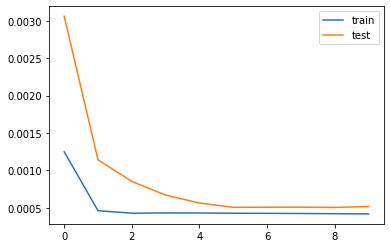

Test RMSE: 32.019


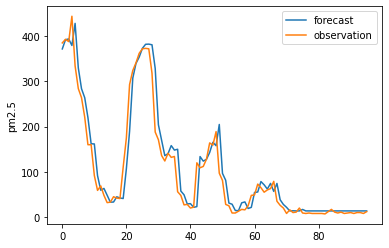

In [6]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import LSTM
import tensorflow as tf
import matplotlib.pyplot as plt


def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')


# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(
    reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=10,
                 strides=1, padding="causal",
                 activation="relu"))
model.add(
    LSTM(
        50,
        input_shape=(
            train_X.shape[1],
            train_X.shape[2]),
        return_sequences=True))
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(50, activation="relu"))
model.add(Dense(1))

#optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer='adam',
    metrics=["mae"])

# fit network
history = model.fit(
    train_X,
    train_y,
    epochs=10,
    batch_size=36,
    validation_data=(
        test_X,
        test_y),
    verbose=2,
    shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


raw = inv_y.size
inv_y = inv_y[-24 * 4:]
inv_yHat = inv_yhat[-24 * 4:]
plt.plot(inv_yHat, label='forecast')
plt.plot(inv_y, label='observation')
plt.ylabel('pm2.5')
plt.legend()
plt.show()